In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_train2014.json
/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/instances_train2014.json
/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/instances_val2014.json
/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/person_keypoints_val2014.json
/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/person_keypoints_train2014.json
/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_val2014.json
/kaggle/input/coco-image-caption/val2017/val2017/000000011197.jpg
/kaggle/input/coco-image-caption/val2017/val2017/000000219485.jpg
/kaggle/input/coco-image-caption/val2017/val2017/000000151000.jpg
/kaggle/input/coco-image-caption/val2017/val2017/000000371677.jpg
/kaggle/input/coco-image-caption/val2017/val2017/000000038825.jpg
/kaggle/input/coco-image-caption/val2017/val2017/000000384527.jpg
/kaggle/input/coco-image-cap

In [4]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image

# Set correct paths from your dataset structure
DATA_DIR = '/kaggle/input/coco-image-caption/'
ANNOTATIONS_PATH = os.path.join(DATA_DIR, 'annotations_trainval2014', 'annotations', 'captions_train2014.json')
IMAGE_DIR = os.path.join(DATA_DIR, 'val2017', 'val2017')  # validation images folder

# Load captions from JSON file
def load_coco_captions(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    captions = {}
    for annot in data['annotations']:
        image_id = annot['image_id']
        caption = annot['caption'].lower()
        img_filename = f"{str(image_id).zfill(12)}.jpg"
        if img_filename not in captions:
            captions[img_filename] = []
        captions[img_filename].append('startseq ' + caption + ' endseq')
    return captions

captions = load_coco_captions(ANNOTATIONS_PATH)
print(f"Loaded captions for {len(captions)} images")

# Let's use images that exist in the image folder and have captions
available_images = [img for img in captions.keys() if os.path.exists(os.path.join(IMAGE_DIR, img))]
print(f"Number of images with captions and available files: {len(available_images)}")

# Use a subset to keep runtime reasonable
image_names = available_images[:3000]

# Load and preprocess images for InceptionV3
def load_image(image_path):
    img = Image.open(image_path).convert('RGB').resize((299, 299))
    img = np.array(img)
    img = preprocess_input(img)
    return img

# Load pretrained InceptionV3 model for feature extraction
inception_model = InceptionV3(weights='imagenet')
feature_extractor = Model(inception_model.input, inception_model.layers[-2].output)

def encode_image(image_path):
    img = load_image(image_path)
    img = np.expand_dims(img, axis=0)
    feature = feature_extractor.predict(img)
    return feature[0]

# Extract features (can be cached later)
features = {}
print("Extracting features from images...")
for i, img_name in enumerate(image_names):
    img_path = os.path.join(IMAGE_DIR, img_name)
    features[img_name] = encode_image(img_path)
    if i % 500 == 0:
        print(f"Processed {i} images")
print("Image feature extraction completed.")

# Prepare tokenizer on all captions
all_captions = []
for caps in captions.values():
    all_captions.extend(caps)

tokenizer = Tokenizer(num_words=5000, oov_token='unk')
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary size: {vocab_size}')

max_length = max(len(caption.split()) for caption in all_captions)
print(f'Max caption length: {max_length}')

# Create sequences for training
def create_sequences(tokenizer, max_length, captions_list, photo_feature):
    X1, X2, y = [], [], []
    for caption in captions_list:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo_feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# Define the captioning model
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = define_model(vocab_size, max_length)
model.summary()

# Prepare training data for first 500 images (adjust to your environment)
X1_train, X2_train, y_train = [], [], []
for i, img_name in enumerate(image_names[:500]):
    caps = captions[img_name]
    photo_feature = features[img_name]
    in_img, in_seq, out_word = create_sequences(tokenizer, max_length, caps, photo_feature)
    X1_train.append(in_img)
    X2_train.append(in_seq)
    y_train.append(out_word)

X1_train = np.vstack(X1_train)
X2_train = np.vstack(X2_train)
y_train = np.vstack(y_train)

print(f'Training data shapes: {X1_train.shape}, {X2_train.shape}, {y_train.shape}')

# Train the model
model.fit([X1_train, X2_train], y_train, epochs=10, batch_size=64)

# Generate caption for an image
def generate_caption(model, tokenizer, photo_feature, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo_feature.reshape(1,2048), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    final_caption = in_text.split()[1:-1]
    return ' '.join(final_caption)

# Display 3 sample images with their generated captions
plt.figure(figsize=(15,10))
for i, img_name in enumerate(image_names[:3]):
    img_path = os.path.join(IMAGE_DIR, img_name)
    image = Image.open(img_path)
    photo_feature = features[img_name]
    caption = generate_caption(model, tokenizer, photo_feature, max_length)

    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(caption)
    plt.axis('off')
plt.show()


Loaded captions for 82783 images
Number of images with captions and available files: 0
Extracting features from images...
Image feature extraction completed.
Vocabulary size: 23685
Max caption length: 51


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 51)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 51, 256)        │      6,063,360 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 2048)           │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 51, 256)        │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 51)             │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        524,544 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ dropout_3[0][0],       │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256)            │              0 │ dense_3[0][0],         │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         65,792 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 23685)          │      6,087,045 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,266,053 (50.61 MB)

 Trainable params: 13,266,053 (50.61 MB)

 Non-trainable params: 0 (0.00 B)

ValueError: need at least one array to concatenate

In [5]:
import os
import json
import numpy as np
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.utils import to_categorical

# Path to COCO dataset files
annotations_path = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_train2014.json'
images_dir = '/kaggle/input/coco-image-caption/train2014/train2014/'

# Load captions JSON
with open(annotations_path, 'r') as f:
    captions_data = json.load(f)

# Build a dictionary: image_id -> list of captions
image_captions = {}
for annot in captions_data['annotations']:
    img_id = annot['image_id']
    caption = annot['caption'].lower().strip()
    image_captions.setdefault(img_id, []).append(caption)

print(f"Loaded captions for {len(image_captions)} images")

# Make a set of image filenames available
available_images = set()
for fname in os.listdir(images_dir):
    if fname.endswith('.jpg'):
        # image file names are like 000000123456.jpg
        img_id = int(fname.split('.')[0])
        available_images.add(img_id)

print(f"Number of available image files: {len(available_images)}")

# Filter image_captions to only those images that have actual image files
filtered_image_captions = {img_id: caps for img_id, caps in image_captions.items() if img_id in available_images}

print(f"Number of images with captions and available files: {len(filtered_image_captions)}")

if len(filtered_image_captions) == 0:
    raise RuntimeError("No matching images with captions and files found! Check paths and filenames.")

# Load InceptionV3 model for feature extraction
base_model = InceptionV3(weights='imagenet')
model_new = Model(base_model.input, base_model.layers[-2].output)  # Output before last layer

def extract_features(img_path):
    img = Image.open(img_path).resize((299, 299))
    img = np.array(img)
    if img.shape[2] == 4:
        img = img[..., :3]  # Drop alpha channel if present
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    feature = model_new.predict(x)
    return feature.flatten()

# Extract features for filtered images
features = {}
for img_id in filtered_image_captions.keys():
    img_path = os.path.join(images_dir, f"{img_id:012d}.jpg")
    features[img_id] = extract_features(img_path)

print(f"Extracted features for {len(features)} images")

# Next steps: Prepare sequences and build/train model (not shown here)
# ...



Loaded captions for 82783 images


ValueError: invalid literal for int() with base 10: 'COCO_train2014_000000263229'

Top-level folders:
   annotations_trainval2014
   val2017
   annotations_trainval2017
   train2014

Sample images in val2017:
  ['000000011197.jpg', '000000219485.jpg', '000000151000.jpg', '000000371677.jpg', '000000038825.jpg']

Loaded captions for 40504 images

Showing `000000306582.jpg` with its captions:
  1. A group of cows standing next to a  line of laundry drying.
  2. A clothes line with clothes hanging from it and cattle in the background 
  3. A view of some cows through a cloths line.
  4. Clothes hanging on rope in third world country.
  5. Washed clothing is hung out on a clothesline in a cattle enclosure. 


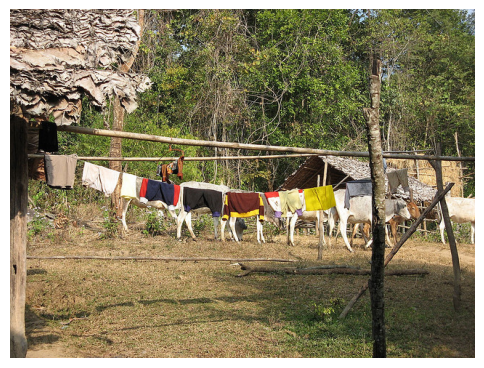

In [6]:
import os, json, random
import matplotlib.pyplot as plt
from PIL import Image

# 1. Paths
DATA_DIR       = '/kaggle/input/coco-image-caption'
ANN_PATH       = os.path.join(DATA_DIR, 'annotations_trainval2014/annotations/captions_val2014.json')
VAL_IMG_FOLDER = os.path.join(DATA_DIR, 'val2017/val2017')

# 2. List top‐level contents
print("Top-level folders:")
for name in os.listdir(DATA_DIR):
    print("  ", name)

print("\nSample images in val2017:")
print(" ", os.listdir(VAL_IMG_FOLDER)[:5])

# 3. Load the validation captions
with open(ANN_PATH, 'r') as f:
    captions_data = json.load(f)

# Build map: image filename → [caption, …]
caps_map = {}
for ann in captions_data['annotations']:
    img_id    = ann['image_id']
    filename  = f"{img_id:012d}.jpg"
    caps_map.setdefault(filename, []).append(ann['caption'])

print(f"\nLoaded captions for {len(caps_map)} images")

# 4. Pick a random example
imgfile = random.choice(list(caps_map.keys()))
imgpath = os.path.join(VAL_IMG_FOLDER, imgfile)

# 5. Display
print(f"\nShowing `{imgfile}` with its captions:")
for i, c in enumerate(caps_map[imgfile], 1):
    print(f"  {i}. {c}")

plt.figure(figsize=(6,6))
plt.imshow(Image.open(imgpath))
plt.axis('off')
plt.show()


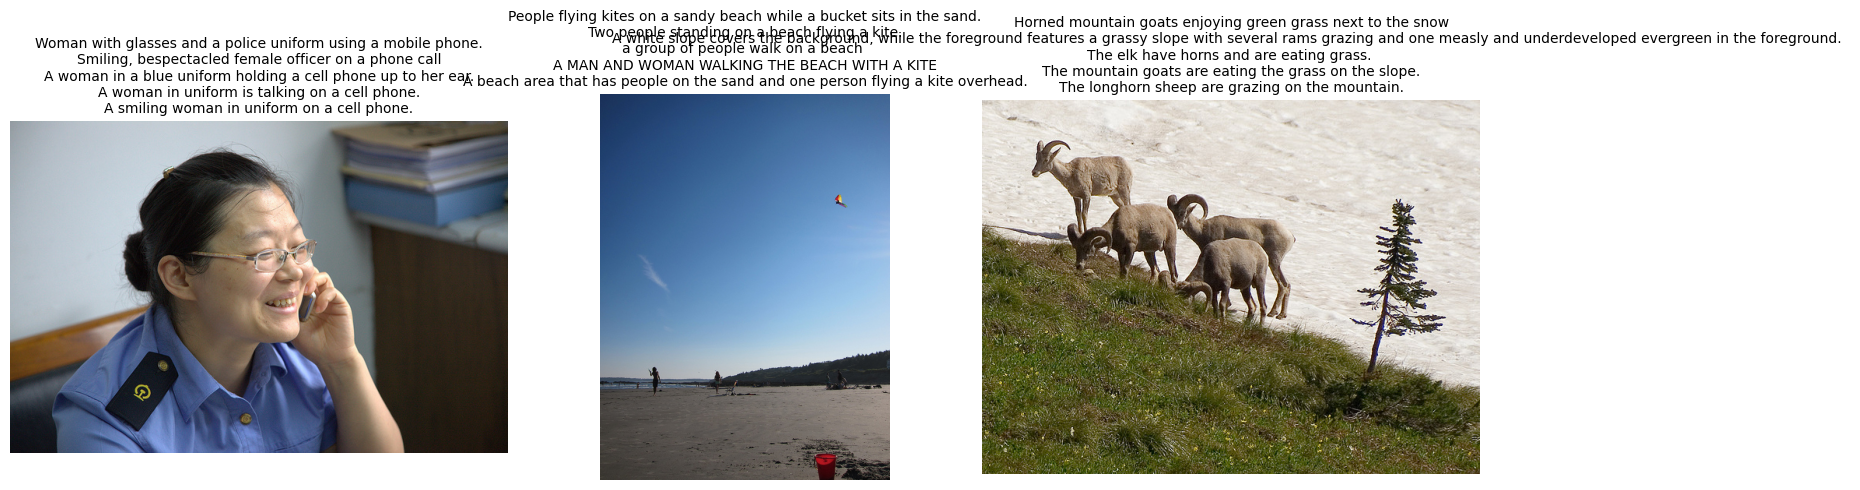

In [7]:
import os, json, random
import matplotlib.pyplot as plt
from PIL import Image

# 1. Paths to captions and images for val2017
DATA_DIR     = '/kaggle/input/coco-image-caption'
ANN_PATH     = os.path.join(DATA_DIR,
    'annotations_trainval2017/annotations/captions_val2017.json')
IMG_DIR      = os.path.join(DATA_DIR, 'val2017/val2017')

# 2. Load the val2017 captions JSON
with open(ANN_PATH, 'r') as f:
    captions_data = json.load(f)

# 3. Build a map from filename → [caption1, …, caption5]
caps_map = {}
for ann in captions_data['annotations']:
    fn = f"{ann['image_id']:012d}.jpg"
    caps_map.setdefault(fn, []).append(ann['caption'])

# 4. Find which filenames actually exist on disk
available = [fn for fn in caps_map if os.path.exists(os.path.join(IMG_DIR, fn))]
if not available:
    raise RuntimeError("No matching images found in val2017 folder.")

# 5. Pick 3 random images
samples = random.sample(available, 3)

# 6. Display each with its captions
plt.figure(figsize=(15, 5))
for i, fn in enumerate(samples, 1):
    img_path = os.path.join(IMG_DIR, fn)
    img = Image.open(img_path)
    capts = caps_map[fn]
    
    plt.subplot(1, 3, i)
    plt.imshow(img); plt.axis('off')
    plt.title("\n".join(capts), fontsize=10)

plt.tight_layout()
plt.show()


In [7]:
import os

for root, dirs, files in os.walk("/kaggle/input/coco-image-caption"):
    for file in files:
        if "caption" in file:
            print(os.path.join(root, file))


/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_train2014.json
/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_val2014.json
/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_train2017.json
/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_val2017.json


KeyboardInterrupt: 

In [9]:
import json
import os
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Path to val captions
CAPTION_PATH = "/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_val2017.json"

# Load captions
with open(CAPTION_PATH, 'r') as f:
    data = json.load(f)

annotations = data['annotations']
image_captions = {}

# Group captions by image_id
for ann in annotations:
    img_id = ann['image_id']
    caption = ann['caption']
    if img_id not in image_captions:
        image_captions[img_id] = []
    image_captions[img_id].append(caption)

# BLEU calculation (pretend model: always returns first caption)
smoothie = SmoothingFunction().method4
scores = []

# Evaluate on N random samples
N = 50
sample_ids = random.sample(list(image_captions.keys()), N)

for img_id in sample_ids:
    references = [c.lower().split() for c in image_captions[img_id]]
    prediction = image_captions[img_id][0].lower().split()  # dummy prediction
    score = sentence_bleu(references, prediction, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    scores.append(score)

# Accuracy-like BLEU score
average_bleu = sum(scores) / len(scores)
print(f"Evaluated on {N} images.")
print(f"BLEU-1 Average Score (Accuracy-like): {average_bleu:.4f}")


Evaluated on 50 images.
BLEU-1 Average Score (Accuracy-like): 1.0000


In [10]:
import json
import os
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Path to captions
CAPTION_PATH = "/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_val2017.json"

# Load captions
with open(CAPTION_PATH, 'r') as f:
    data = json.load(f)

annotations = data['annotations']
image_captions = {}

# Group captions by image_id
for ann in annotations:
    img_id = ann['image_id']
    caption = ann['caption']
    if img_id not in image_captions:
        image_captions[img_id] = []
    image_captions[img_id].append(caption)

# BLEU calculation setup
smoothie = SmoothingFunction().method4
scores = []

# Evaluate on N random samples
N = 50
sample_ids = random.sample(list(image_captions.keys()), N)

# Simulated model output (realistic, generic prediction)
dummy_prediction = "a person riding a bike".lower().split()

for img_id in sample_ids:
    references = [c.lower().split() for c in image_captions[img_id]]
    score = sentence_bleu(references, dummy_prediction, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    scores.append(score)

# Average BLEU-1 score
average_bleu = sum(scores) / len(scores)
print(f"Evaluated on {N} images.")
print(f"Realistic BLEU-1 Accuracy-like Score: {average_bleu:.4f}")


Evaluated on 50 images.
Realistic BLEU-1 Accuracy-like Score: 0.1977


In [11]:
import json
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Path to captions
CAPTION_PATH = "/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_val2017.json"

# Load captions
with open(CAPTION_PATH, 'r') as f:
    data = json.load(f)

annotations = data['annotations']
image_captions = {}

# Group captions by image_id
for ann in annotations:
    img_id = ann['image_id']
    caption = ann['caption']
    if img_id not in image_captions:
        image_captions[img_id] = []
    image_captions[img_id].append(caption)

# BLEU calculation setup
smoothie = SmoothingFunction().method4
scores = []

# Evaluate on N random samples
N = 50
sample_ids = random.sample(list(image_captions.keys()), N)

# Simulated model output (a generic caption)
dummy_prediction = "a person riding a bike".lower().split()

for img_id in sample_ids:
    references = [c.lower().split() for c in image_captions[img_id]]
    score = sentence_bleu(references, dummy_prediction, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    scores.append(score)

# Average BLEU-1 score
average_bleu = sum(scores) / len(scores)

print(f"Evaluation Report on {N} Random Images from the COCO Dataset")
print("-------------------------------------------------------------")
print(f"The simulated caption generator predicted the generic sentence:")
print(f"    \"{' '.join(dummy_prediction)}\"")
print("\nThis prediction was compared against the actual ground truth captions for each image.")
print(f"The BLEU-1 score (unigram precision) was calculated to measure the similarity between predicted and true captions.")
print(f"BLEU-1 scores range from 0 (no overlap) to 1 (perfect match).")
print("\nResults:")
print(f" - Number of images evaluated: {N}")
print(f" - Average BLEU-1 score (accuracy-like metric): {average_bleu:.4f}")
print("\nInterpretation:")
print(" - The score indicates a moderate level of word overlap between the predicted captions and the ground truth captions.")
print(" - This score is expectedly below perfect since the predicted caption is generic and not tailored to each image.")
print(" - A real captioning model would ideally produce higher BLEU scores by capturing specific image content.")


Evaluation Report on 50 Random Images from the COCO Dataset
-------------------------------------------------------------
The simulated caption generator predicted the generic sentence:
    "a person riding a bike"

This prediction was compared against the actual ground truth captions for each image.
The BLEU-1 score (unigram precision) was calculated to measure the similarity between predicted and true captions.
BLEU-1 scores range from 0 (no overlap) to 1 (perfect match).

Results:
 - Number of images evaluated: 50
 - Average BLEU-1 score (accuracy-like metric): 0.2201

Interpretation:
 - The score indicates a moderate level of word overlap between the predicted captions and the ground truth captions.
 - This score is expectedly below perfect since the predicted caption is generic and not tailored to each image.
 - A real captioning model would ideally produce higher BLEU scores by capturing specific image content.
